# MCMC

Brief notebook that demonstrates the MCMC generic functions (not cryo-EM specific) implemented in this repository. 

In [1]:
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config

from simplecryoem.sampling import mcmc_sampling, proposal_hmc

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### Generate samples from a multivariate normal distribution

(-12.0, 12.0)

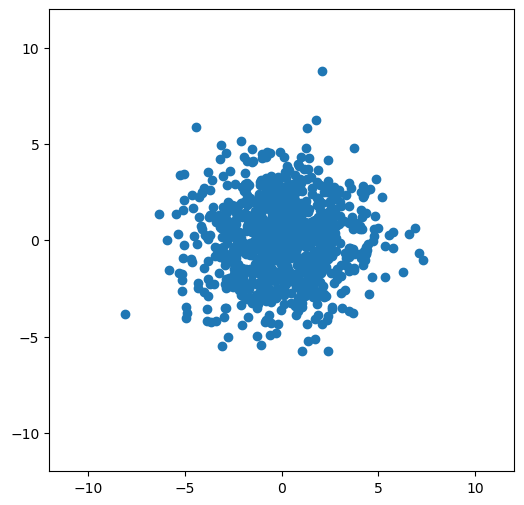

In [3]:
key = random.PRNGKey(10)

N_samples = 1000
k = 10
M = jnp.zeros(k)
# c = jnp.array([[1,0],[0,10]])
# c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,)) * 10)
D = d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1 / jnp.diag(D)) @ Q

S = random.multivariate_normal(sk[2], M, C, (N_samples,))
plt.scatter(S[:, 0], S[:, 1])
plt.xlim(-12, 12)
plt.ylim(-12, 12)

### Define the functions required by the sampler: $\log(\Pi(x))$ and $\nabla\log(\Pi(x))$

where $\Pi(x)$ the target distribution.

In [4]:
logPi = lambda x: -1 / 2 * (x - M) @ C_inv @ (x - M) - jnp.log(
    jnp.sqrt((2 * jnp.pi) ** k * jnp.linalg.det(C))
)
gradLogPi = jax.grad(logPi)

pi = lambda x: jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

### Hamiltonian Monte Carlo

In [5]:
# JIT-compile the proposal function


@jax.jit
def proposal_hmc_jit(key, x0, logPiX0, dt_list):
    return proposal_hmc(key, x0, logPiX0, logPi, gradLogPi, dt_list, L=100)

In [6]:
# Set the params required by the sampling function

key1, key2 = random.split(key)
x0 = random.normal(key1, (k,))
logPiX0 = logPi(x0)
dt_list = jnp.array([0.1])
x1, r, logPiX1, logPiX0 = proposal_hmc_jit(key2, x0, logPiX0, dt_list)
proposal_params_hmc = {"dt_list": jnp.array([0.001, 0.01, 0.1, 1, 10])}

In [7]:
# And finally sample

x_mean_hmc, r_hmc, samples_hmc = mcmc_sampling(
    key, proposal_hmc_jit, x0, N_samples, proposal_params_hmc, save_samples=1
)

  MCMC sample 50, posterior val = -21.408304134337705, a = 0.9983501995975583
  MCMC sample 100, posterior val = -19.967093457831744, a = 1.0
  MCMC sample 150, posterior val = -20.77849792355822, a = 0.0
  MCMC sample 200, posterior val = -19.057942838334068, a = 0.9999847322135125
  MCMC sample 250, posterior val = -22.210344054358853, a = 0.8875969071990412
  MCMC sample 300, posterior val = -25.208976776398398, a = 0.9999998509277259
  MCMC sample 350, posterior val = -20.200232857769343, a = 1.0
  MCMC sample 400, posterior val = -19.34142226465706, a = 1.0
  MCMC sample 450, posterior val = -20.78332697523132, a = 1.0
  MCMC sample 500, posterior val = -19.182931261787804, a = 1.0
  MCMC sample 550, posterior val = -19.761744899322387, a = 1.0
  MCMC sample 600, posterior val = -23.99538011417316, a = 0.9999999447254113
  MCMC sample 650, posterior val = -18.595038184250754, a = 0.96981632593658
  MCMC sample 700, posterior val = -19.63940964598975, a = 1.0
  MCMC sample 750, pos

In [8]:
# Some useful functions


def plot_mcmc_samples(samples, r, x0, M, C):
    """Plot the samples as well as the sample acceptance ratio."""

    plt.rcParams["figure.figsize"] = 16, 8

    plt.subplot(1, 2, 1)
    plt.plot(x0[0], x0[1], "ro")
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.title("Samples (x0 in red)")

    plt.subplot(1, 2, 2)
    plt.plot(r, ".")
    plt.title("Sample acceptance ratio")

    plt.rcParams["figure.figsize"] = 8, 8

    M_est = jnp.mean(samples, axis=0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est) / jnp.linalg.norm(C))


def get_norm_conv(samples, M, C):
    """Function to compute the error between the sample mean and covariance
    and the true mean and covariance matrix."""

    norm_m = []
    norm_c = []
    for i in range(10, N_samples):
        if jnp.mod(i, 50) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis=0) - M)
            Cerr = jnp.linalg.norm(
                jnp.cov(samples[:i].transpose()) - C
            ) / jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

Mean error = 0.4713543909154583
Covariance error = 0.18372624168139173


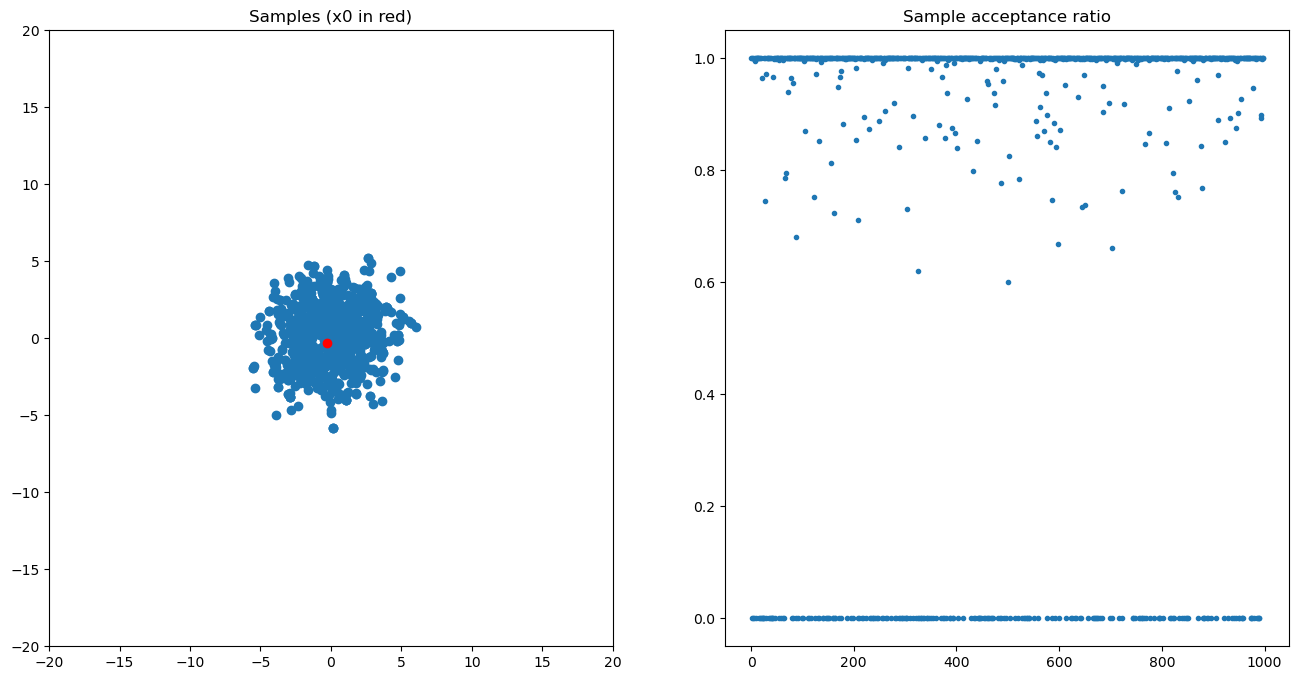

In [9]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [10]:
# Compute the errors
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)
norm_m_an, norm_c_an = get_norm_conv(S, M, C)

In [11]:
# 1/sqrt(N) for comparison
xx = []
for i in range(50, N_samples):
    if jnp.mod(i, 50) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1 / jnp.sqrt(xx)

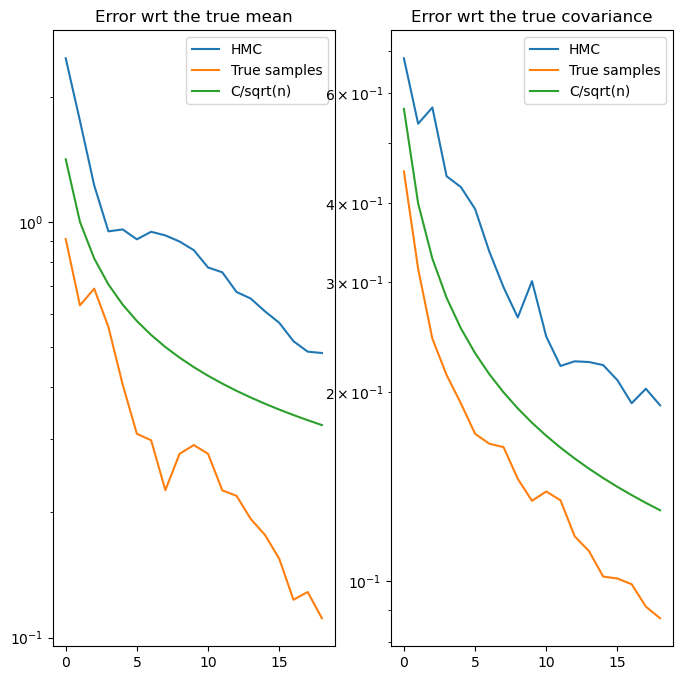

In [12]:
plt.subplot(121)
plt.semilogy(norm_m_hmc)
plt.semilogy(norm_m_an)
plt.semilogy(yy * 10)
plt.title("Error wrt the true mean")
plt.legend(["HMC", "True samples", "C/sqrt(n)"])

plt.subplot(122)
plt.semilogy(norm_c_hmc)
plt.semilogy(norm_c_an)
plt.semilogy(yy * 4)
plt.title("Error wrt the true covariance")
plt.legend(["HMC", "True samples", "C/sqrt(n)"])